## The problematic eigenvalues for BDF5

Define
$$
\mu(x,\Delta x)=\left\{\left|\frac {\left|\xi(\Delta x \lambda)\right|-1}{\Delta x}\right|:\lambda\in \sigma\left(A+xB\right)\right\}.
$$

The following plots show for each value of $x\in 13,12,\cdots,-9,-10$, how the (normalized) number of problematic eigenvalues (outside of the absolute stability region of BDF3) change with respect to $\Delta x$, where the number of Fourier modes is fixed at $8000$ and $\beta=2$ for all plots. Besides, for each value of $\Delta x$, for those problematic eigenvalues, we also compute the mean of $\mu(x,\Delta x)$.

In [1]:
using TracyWidomBeta,LinearAlgebra,Statistics,SparseArrays,Distributions,Trapz,ApproxFun,SpecialFunctions
using RandomMatrices,Plots,LaTeXStrings,TypedTables,StatsBase,FFTW

In [2]:
ρ = (α,z) -> (z.^(length(α)-1:-1:0))'*α
σ = (β,z) -> (z.^(length(β)-1:-1:0))'*β
R = (α,β,z) -> ρ(α,z)/σ(β,z)
function find_roots(c) # supposing that the leading order coefficient is 1
    # c contains the remaining coefficients
    r = length(c)
    A = zeros(Complex{Float64},r,r)
    A[1,:] = -c
    A[2:end,1:end-1] = A[2:end,1:end-1] + I # add identity matrix to lower-left block
    return eigvals(A)
end
function compute_roots(α,β,z)
    r = length(α)-1
    c = α-z*β
    if α[1]-z*β[1] ≈ 0.
        λ = find_roots(c[3:end]/c[2])
    else
        λ = find_roots(c[2:end]/c[1]) # let's suppose that first and second coefficients don't vanish simultaneously
    end
    return λ
end
function check_condition(λ)
    if maximum(abs.(λ)) > 1
        return 0
    else
        for i = 1:length(λ)
            if abs(λ[i]) ≈ 1. && sum(map(t -> λ[i] ≈ t,λ)) > 1
                return 0
            end
        end
    end
    return 1
end
function check_condition2(λ)
    ξ_rest=zeros(ComplexF64,0)
    for i=1:length(λ)
        if abs(λ[i])>1
            append!(ξ_rest,λ[i])
        elseif abs(λ[i]) ≈ 1. && sum(map(t -> λ[i] ≈ t,λ)) > 1
            append!(ξ_rest,λ[i])
        end
    end
    return ξ_rest
end
function root_condition(α,β,z)
    return compute_roots(α,β,z) |> check_condition
end

root_condition (generic function with 1 method)

Construct the matrices.

In [3]:
β=2;
M_f=1000;#just some random value
mgrid=(n,L) -> L*(1:n)/n;
θ=mgrid(M_f,pi);
M_s=8000;
h=(1/M_f)*pi;
method="spectral";
l=10;
(A,B)=TracyWidomBeta.matrix_gen(β;method,M_f,M_s,h,θ,l);

For $x=-10$, we have

In [4]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm10=zeros(1,length(Delta_x));r_rightm10=zeros(1,length(Delta_x));
v_leftm10=zeros(1,length(Delta_x));v_rightm10=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-10*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm10[j]=length(z_left)/M_s;
    r_rightm10[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm10[j]=0
    end
    if length(ξ_right)==0
        v_rightm10[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm10[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm10[j]=mean(μ_right)
    end
end

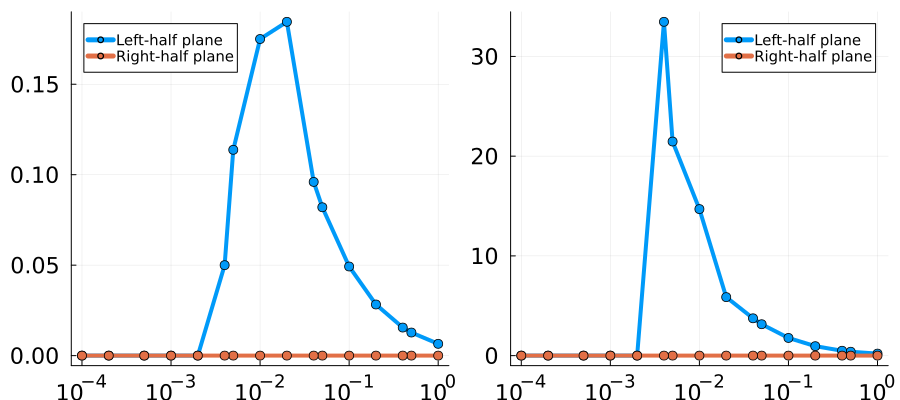

In [5]:
p_m10r=Plots.plot();
p_m10r=plot!(Delta_x.*(-1),vec(r_leftm10),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10r=plot!(Delta_x.*(-1),vec(r_rightm10),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10v=Plots.plot();
p_m10v=plot!(Delta_x.*(-1),vec(v_leftm10),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10v=plot!(Delta_x.*(-1),vec(v_rightm10),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m10r,p_m10v,size=(900,400))

In [6]:
t_m10=Table(Δx=Delta_x,ratio_left=vec(r_leftm10),mean_left=vec(v_leftm10),ratio_right=vec(r_rightm10),mean_right=vec(v_rightm10))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0065      0.200496   0.0          0.0
 2  │ -0.5     0.01275     0.388041   0.0          0.0
 3  │ -0.4     0.0155      0.486335   0.0          0.0
 4  │ -0.2     0.02825     0.946404   0.0          0.0
 5  │ -0.1     0.04925     1.76928    0.0          0.0
 6  │ -0.05    0.082       3.14648    0.0          0.0
 7  │ -0.04    0.096       3.74088    0.0          0.0
 8  │ -0.02    0.1845      5.86342    0.0          0.0
 9  │ -0.01    0.175       14.6924    0.0          0.0
 10 │ -0.005   0.11375     21.465     0.0          0.0
 11 │ -0.004   0.05        33.4681    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-9$, we have

In [7]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm9=zeros(1,length(Delta_x));r_rightm9=zeros(1,length(Delta_x));
v_leftm9=zeros(1,length(Delta_x));v_rightm9=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-9*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm9[j]=length(z_left)/M_s;
    r_rightm9[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm9[j]=0
    end
    if length(ξ_right)==0
        v_rightm9[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm9[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm9[j]=mean(μ_right)
    end
end

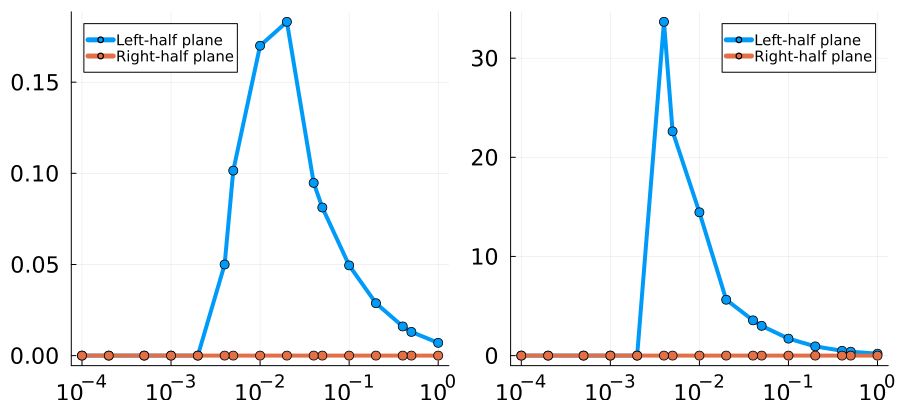

In [8]:
p_m9r=Plots.plot();
p_m9r=plot!(Delta_x.*(-1),vec(r_leftm9),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9r=plot!(Delta_x.*(-1),vec(r_rightm9),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9v=Plots.plot();
p_m9v=plot!(Delta_x.*(-1),vec(v_leftm9),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9v=plot!(Delta_x.*(-1),vec(v_rightm9),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m9r,p_m9v,size=(900,400))

In [9]:
t_m9=Table(Δx=Delta_x,ratio_left=vec(r_leftm9),mean_left=vec(v_leftm9),ratio_right=vec(r_rightm9),mean_right=vec(v_rightm9))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.007       0.193779   0.0          0.0
 2  │ -0.5     0.013       0.391851   0.0          0.0
 3  │ -0.4     0.016       0.482466   0.0          0.0
 4  │ -0.2     0.02875     0.930358   0.0          0.0
 5  │ -0.1     0.0495      1.71062    0.0          0.0
 6  │ -0.05    0.08125     3.00193    0.0          0.0
 7  │ -0.04    0.09475     3.55761    0.0          0.0
 8  │ -0.02    0.183125    5.63352    0.0          0.0
 9  │ -0.01    0.17        14.4553    0.0          0.0
 10 │ -0.005   0.1015      22.6168    0.0          0.0
 11 │ -0.004   0.05        33.6649    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-8$, we have

In [10]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm8=zeros(1,length(Delta_x));r_rightm8=zeros(1,length(Delta_x));
v_leftm8=zeros(1,length(Delta_x));v_rightm8=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-8*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm8[j]=length(z_left)/M_s;
    r_rightm8[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm8[j]=0
    end
    if length(ξ_right)==0
        v_rightm8[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm8[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm8[j]=mean(μ_right)
    end
end

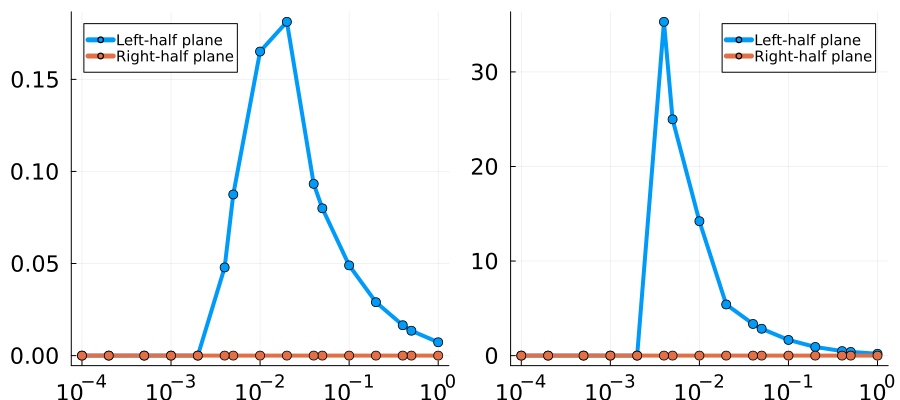

In [11]:
p_m8r=Plots.plot();
p_m8r=plot!(Delta_x.*(-1),vec(r_leftm8),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8r=plot!(Delta_x.*(-1),vec(r_rightm8),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8v=Plots.plot();
p_m8v=plot!(Delta_x.*(-1),vec(v_leftm8),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8v=plot!(Delta_x.*(-1),vec(v_rightm8),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m8r,p_m8v,size=(900,400))

In [12]:
t_m8=Table(Δx=Delta_x,ratio_left=vec(r_leftm8),mean_left=vec(v_leftm8),ratio_right=vec(r_rightm8),mean_right=vec(v_rightm8))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00725     0.194994   0.0          0.0
 2  │ -0.5     0.0135      0.387471   0.0          0.0
 3  │ -0.4     0.0165      0.476753   0.0          0.0
 4  │ -0.2     0.029       0.913588   0.0          0.0
 5  │ -0.1     0.049       1.65612    0.0          0.0
 6  │ -0.05    0.08        2.84049    0.0          0.0
 7  │ -0.04    0.09325     3.34553    0.0          0.0
 8  │ -0.02    0.18125     5.40668    0.0          0.0
 9  │ -0.01    0.165125    14.2153    0.0          0.0
 10 │ -0.005   0.0875      24.9865    0.0          0.0
 11 │ -0.004   0.047875    35.2978    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-7$, we have

In [13]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm7=zeros(1,length(Delta_x));r_rightm7=zeros(1,length(Delta_x));
v_leftm7=zeros(1,length(Delta_x));v_rightm7=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-7*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm7[j]=length(z_left)/M_s;
    r_rightm7[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm7[j]=0
    end
    if length(ξ_right)==0
        v_rightm7[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm7[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm7[j]=mean(μ_right)
    end
end

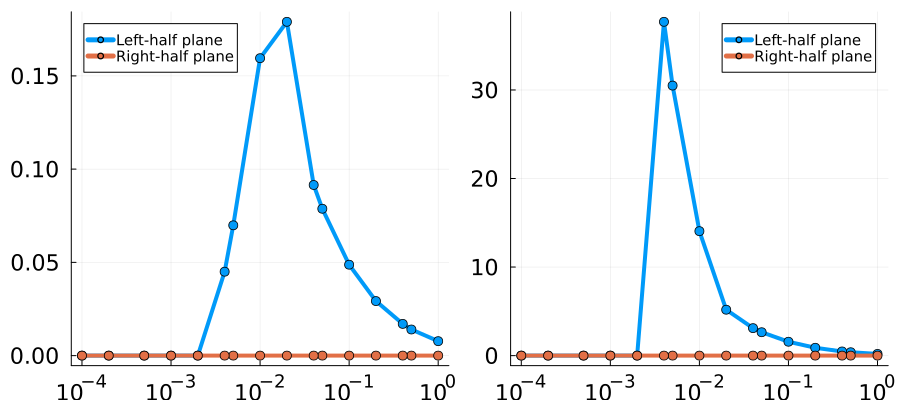

In [14]:
p_m7r=Plots.plot();
p_m7r=plot!(Delta_x.*(-1),vec(r_leftm7),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7r=plot!(Delta_x.*(-1),vec(r_rightm7),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7v=Plots.plot();
p_m7v=plot!(Delta_x.*(-1),vec(v_leftm7),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7v=plot!(Delta_x.*(-1),vec(v_rightm7),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m7r,p_m7v,size=(900,400))

In [15]:
t_m7=Table(Δx=Delta_x,ratio_left=vec(r_leftm7),mean_left=vec(v_leftm7),ratio_right=vec(r_rightm7),mean_right=vec(v_rightm7))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00775     0.190177   0.0          0.0
 2  │ -0.5     0.014       0.381255   0.0          0.0
 3  │ -0.4     0.017       0.467976   0.0          0.0
 4  │ -0.2     0.02925     0.884112   0.0          0.0
 5  │ -0.1     0.04875     1.56627    0.0          0.0
 6  │ -0.05    0.07875     2.64098    0.0          0.0
 7  │ -0.04    0.0915      3.10307    0.0          0.0
 8  │ -0.02    0.179       5.18253    0.0          0.0
 9  │ -0.01    0.1595      14.0567    0.0          0.0
 10 │ -0.005   0.069875    30.498     0.0          0.0
 11 │ -0.004   0.045       37.6998    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-6$, we have

In [33]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm6=zeros(1,length(Delta_x));r_rightm6=zeros(1,length(Delta_x));
v_leftm6=zeros(1,length(Delta_x));v_rightm6=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-6*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm6[j]=length(z_left)/M_s;
    r_rightm6[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm6[j]=0
    end
    if length(ξ_right)==0
        v_rightm6[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm6[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm6[j]=mean(μ_right)
    end
end

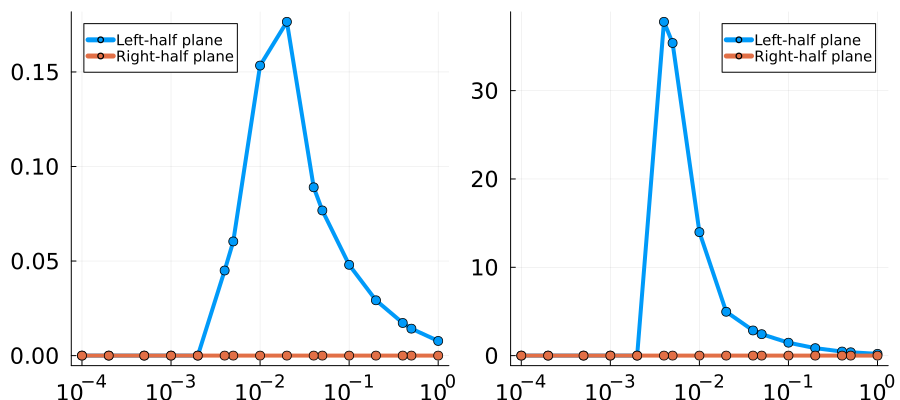

In [35]:
p_m6r=Plots.plot();
p_m6r=plot!(Delta_x.*(-1),vec(r_leftm6),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6r=plot!(Delta_x.*(-1),vec(r_rightm6),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6v=Plots.plot();
p_m6v=plot!(Delta_x.*(-1),vec(v_leftm6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6v=plot!(Delta_x.*(-1),vec(v_rightm6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m6r,p_m6v,size=(900,400))

In [37]:
t_m6=Table(Δx=Delta_x,ratio_left=vec(r_leftm6),mean_left=vec(v_leftm6),ratio_right=vec(r_rightm6),mean_right=vec(v_rightm6))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00775     0.198262   0.0          0.0
 2  │ -0.5     0.01425     0.378292   0.0          0.0
 3  │ -0.4     0.01725     0.459798   0.0          0.0
 4  │ -0.2     0.02925     0.844445   0.0          0.0
 5  │ -0.1     0.048       1.46047    0.0          0.0
 6  │ -0.05    0.07675     2.42716    0.0          0.0
 7  │ -0.04    0.089       2.84605    0.0          0.0
 8  │ -0.02    0.1765      4.96184    0.0          0.0
 9  │ -0.01    0.153375    13.9802    0.0          0.0
 10 │ -0.005   0.060375    35.394     0.0          0.0
 11 │ -0.004   0.045       37.7907    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-5$, we have

In [39]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm5=zeros(1,length(Delta_x));r_rightm5=zeros(1,length(Delta_x));
v_leftm5=zeros(1,length(Delta_x));v_rightm5=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-5*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm5[j]=length(z_left)/M_s;
    r_rightm5[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm5[j]=0
    end
    if length(ξ_right)==0
        v_rightm5[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm5[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm5[j]=mean(μ_right)
    end
end

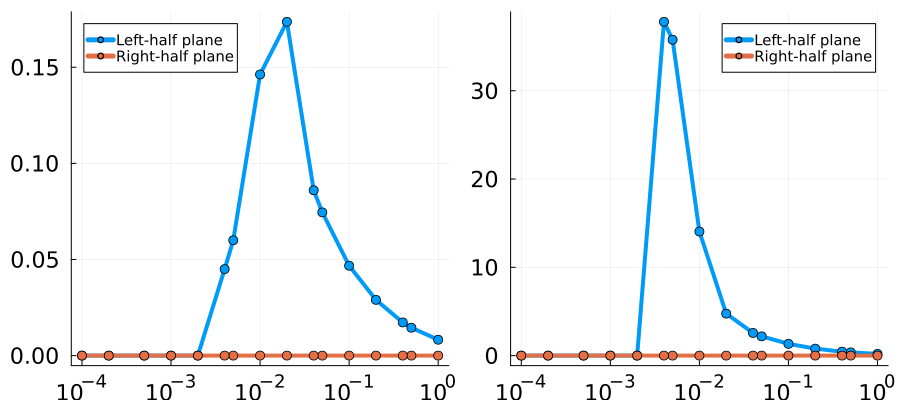

In [41]:
p_m5r=Plots.plot();
p_m5r=plot!(Delta_x.*(-1),vec(r_leftm5),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5r=plot!(Delta_x.*(-1),vec(r_rightm5),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5v=Plots.plot();
p_m5v=plot!(Delta_x.*(-1),vec(v_leftm5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5v=plot!(Delta_x.*(-1),vec(v_rightm5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m5r,p_m5v,size=(900,400))

In [43]:
t_m5=Table(Δx=Delta_x,ratio_left=vec(r_leftm5),mean_left=vec(v_leftm5),ratio_right=vec(r_rightm5),mean_right=vec(v_rightm5))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00825     0.192487   0.0          0.0
 2  │ -0.5     0.0145      0.367664   0.0          0.0
 3  │ -0.4     0.01725     0.447392   0.0          0.0
 4  │ -0.2     0.029       0.787742   0.0          0.0
 5  │ -0.1     0.04675     1.33283    0.0          0.0
 6  │ -0.05    0.0745      2.18129    0.0          0.0
 7  │ -0.04    0.086       2.56509    0.0          0.0
 8  │ -0.02    0.173625    4.75329    0.0          0.0
 9  │ -0.01    0.14625     14.0525    0.0          0.0
 10 │ -0.005   0.06        35.7823    0.0          0.0
 11 │ -0.004   0.045       37.8111    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-4$, we have

In [45]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm4=zeros(1,length(Delta_x));r_rightm4=zeros(1,length(Delta_x));
v_leftm4=zeros(1,length(Delta_x));v_rightm4=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-4*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm4[j]=length(z_left)/M_s;
    r_rightm4[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm4[j]=0
    end
    if length(ξ_right)==0
        v_rightm4[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm4[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm4[j]=mean(μ_right)
    end
end

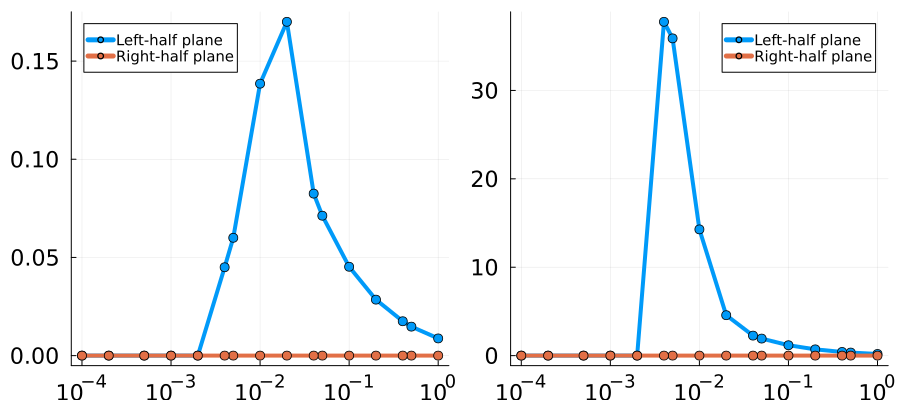

In [47]:
p_m4r=Plots.plot();
p_m4r=plot!(Delta_x.*(-1),vec(r_leftm4),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4r=plot!(Delta_x.*(-1),vec(r_rightm4),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4v=Plots.plot();
p_m4v=plot!(Delta_x.*(-1),vec(v_leftm4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4v=plot!(Delta_x.*(-1),vec(v_rightm4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m4r,p_m4v,size=(900,400))

In [49]:
t_m4=Table(Δx=Delta_x,ratio_left=vec(r_leftm4),mean_left=vec(v_leftm4),ratio_right=vec(r_rightm4),mean_right=vec(v_rightm4))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00875     0.183202   0.0          0.0
 2  │ -0.5     0.01475     0.34417    0.0          0.0
 3  │ -0.4     0.0175      0.41147    0.0          0.0
 4  │ -0.2     0.0285      0.706375   0.0          0.0
 5  │ -0.1     0.04525     1.1726     0.0          0.0
 6  │ -0.05    0.07125     1.92568    0.0          0.0
 7  │ -0.04    0.0825      2.26079    0.0          0.0
 8  │ -0.02    0.17        4.5726     0.0          0.0
 9  │ -0.01    0.1385      14.2798    0.0          0.0
 10 │ -0.005   0.06        35.8903    0.0          0.0
 11 │ -0.004   0.045       37.7612    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-3$, we have

In [51]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm3=zeros(1,length(Delta_x));r_rightm3=zeros(1,length(Delta_x));
v_leftm3=zeros(1,length(Delta_x));v_rightm3=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-3*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm3[j]=length(z_left)/M_s;
    r_rightm3[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm3[j]=0
    end
    if length(ξ_right)==0
        v_rightm3[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm3[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm3[j]=mean(μ_right)
    end
end

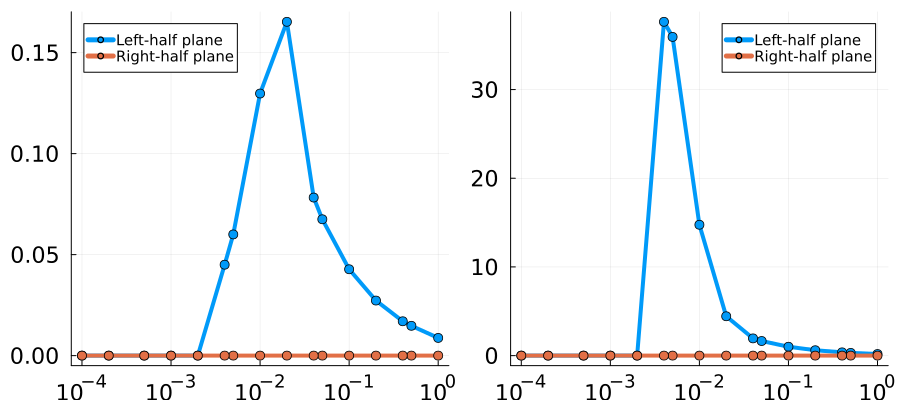

In [53]:
p_m3r=Plots.plot();
p_m3r=plot!(Delta_x.*(-1),vec(r_leftm3),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3r=plot!(Delta_x.*(-1),vec(r_rightm3),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3v=Plots.plot();
p_m3v=plot!(Delta_x.*(-1),vec(v_leftm3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3v=plot!(Delta_x.*(-1),vec(v_rightm3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m3r,p_m3v,size=(900,400))

In [55]:
t_m3=Table(Δx=Delta_x,ratio_left=vec(r_leftm3),mean_left=vec(v_leftm3),ratio_right=vec(r_rightm3),mean_right=vec(v_rightm3))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00875     0.176473   0.0          0.0
 2  │ -0.5     0.01475     0.305062   0.0          0.0
 3  │ -0.4     0.017       0.366904   0.0          0.0
 4  │ -0.2     0.02725     0.606071   0.0          0.0
 5  │ -0.1     0.04275     0.998315   0.0          0.0
 6  │ -0.05    0.0675      1.64582    0.0          0.0
 7  │ -0.04    0.07825     1.94085    0.0          0.0
 8  │ -0.02    0.16525     4.43736    0.0          0.0
 9  │ -0.01    0.12975     14.7558    0.0          0.0
 10 │ -0.005   0.06        35.9385    0.0          0.0
 11 │ -0.004   0.045       37.6412    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-2$, we have

In [57]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm2=zeros(1,length(Delta_x));r_rightm2=zeros(1,length(Delta_x));
v_leftm2=zeros(1,length(Delta_x));v_rightm2=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-2*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm2[j]=length(z_left)/M_s;
    r_rightm2[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm2[j]=0
    end
    if length(ξ_right)==0
        v_rightm2[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm2[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm2[j]=mean(μ_right)
    end
end

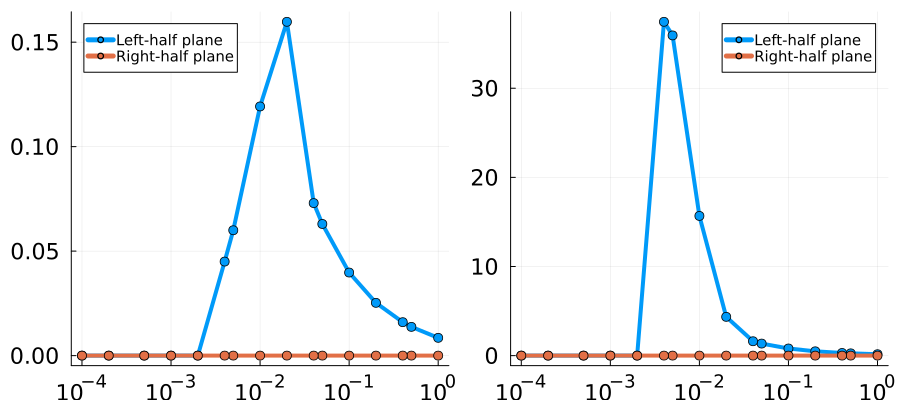

In [59]:
p_m2r=Plots.plot();
p_m2r=plot!(Delta_x.*(-1),vec(r_leftm2),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2r=plot!(Delta_x.*(-1),vec(r_rightm2),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2v=Plots.plot();
p_m2v=plot!(Delta_x.*(-1),vec(v_leftm2),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2v=plot!(Delta_x.*(-1),vec(v_rightm2),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m2r,p_m2v,size=(900,400))

In [61]:
t_m2=Table(Δx=Delta_x,ratio_left=vec(r_leftm2),mean_left=vec(v_leftm2),ratio_right=vec(r_rightm2),mean_right=vec(v_rightm2))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0085      0.154903   0.0          0.0
 2  │ -0.5     0.01375     0.253784   0.0          0.0
 3  │ -0.4     0.016       0.295798   0.0          0.0
 4  │ -0.2     0.02525     0.481681   0.0          0.0
 5  │ -0.1     0.03975     0.797685   0.0          0.0
 6  │ -0.05    0.063       1.34901    0.0          0.0
 7  │ -0.04    0.073       1.61044    0.0          0.0
 8  │ -0.02    0.15975     4.34738    0.0          0.0
 9  │ -0.01    0.11925     15.6721    0.0          0.0
 10 │ -0.005   0.06        35.9263    0.0          0.0
 11 │ -0.004   0.045       37.4514    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-1$, we have

In [63]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm1=zeros(1,length(Delta_x));r_rightm1=zeros(1,length(Delta_x));
v_leftm1=zeros(1,length(Delta_x));v_rightm1=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-1*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm1[j]=length(z_left)/M_s;
    r_rightm1[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm1[j]=0
    end
    if length(ξ_right)==0
        v_rightm1[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm1[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm1[j]=mean(μ_right)
    end
end

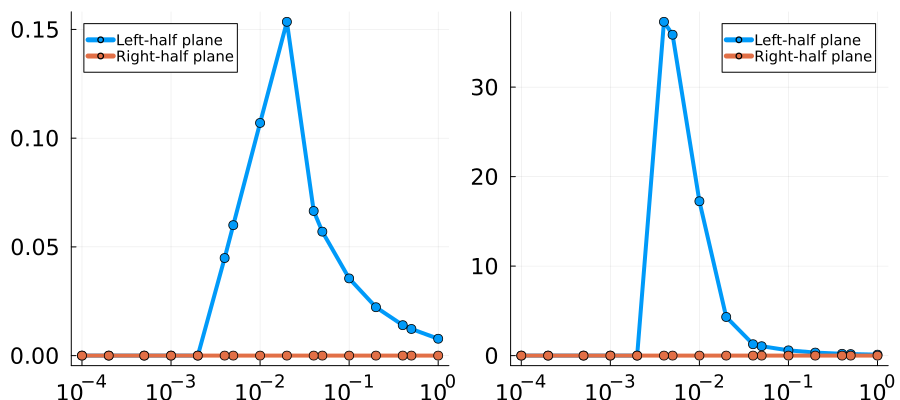

In [65]:
p_m1r=Plots.plot();
p_m1r=plot!(Delta_x.*(-1),vec(r_leftm1),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1r=plot!(Delta_x.*(-1),vec(r_rightm1),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1v=Plots.plot();
p_m1v=plot!(Delta_x.*(-1),vec(v_leftm1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1v=plot!(Delta_x.*(-1),vec(v_rightm1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m1r,p_m1v,size=(900,400))

In [67]:
t_m1=Table(Δx=Delta_x,ratio_left=vec(r_leftm1),mean_left=vec(v_leftm1),ratio_right=vec(r_rightm1),mean_right=vec(v_rightm1))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00775     0.106949   0.0          0.0
 2  │ -0.5     0.01225     0.169474   0.0          0.0
 3  │ -0.4     0.014       0.201566   0.0          0.0
 4  │ -0.2     0.02225     0.338158   0.0          0.0
 5  │ -0.1     0.0355      0.586936   0.0          0.0
 6  │ -0.05    0.057       1.04923    0.0          0.0
 7  │ -0.04    0.0665      1.27199    0.0          0.0
 8  │ -0.02    0.1535      4.31512    0.0          0.0
 9  │ -0.01    0.107       17.2466    0.0          0.0
 10 │ -0.005   0.06        35.8533    0.0          0.0
 11 │ -0.004   0.044875    37.2957    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=0$, we have

In [69]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left0=zeros(1,length(Delta_x));r_right0=zeros(1,length(Delta_x));
v_left0=zeros(1,length(Delta_x));v_right0=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A-0*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left0[j]=length(z_left)/M_s;
    r_right0[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left0[j]=0
    end
    if length(ξ_right)==0
        v_right0[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left0[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right0[j]=mean(μ_right)
    end
end

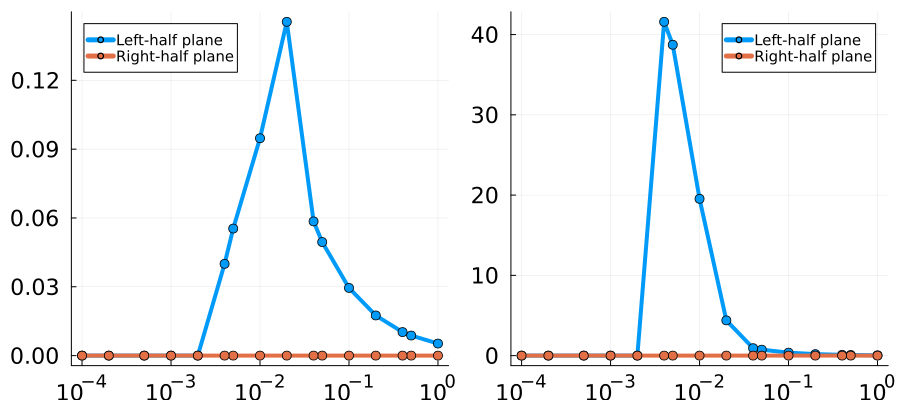

In [71]:
p_0r=Plots.plot();
p_0r=plot!(Delta_x.*(-1),vec(r_left0),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0r=plot!(Delta_x.*(-1),vec(r_right0),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0v=Plots.plot();
p_0v=plot!(Delta_x.*(-1),vec(v_left0),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0v=plot!(Delta_x.*(-1),vec(v_right0),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_0r,p_0v,size=(900,400))

In [73]:
t_0=Table(Δx=Delta_x,ratio_left=vec(r_left0),mean_left=vec(v_left0),ratio_right=vec(r_right0),mean_right=vec(v_right0))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00525     0.0363949  0.0          0.0
 2  │ -0.5     0.00875     0.0740885  0.0          0.0
 3  │ -0.4     0.01025     0.0935447  0.0          0.0
 4  │ -0.2     0.0175      0.184703   0.0          0.0
 5  │ -0.1     0.0295      0.368828   0.0          0.0
 6  │ -0.05    0.0495      0.739509   0.0          0.0
 7  │ -0.04    0.0585      0.9247     0.0          0.0
 8  │ -0.02    0.1455      4.38814    0.0          0.0
 9  │ -0.01    0.09475     19.5365    0.0          0.0
 10 │ -0.005   0.055375    38.73      0.0          0.0
 11 │ -0.004   0.04        41.5887    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=1$, we have

In [75]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left1=zeros(1,length(Delta_x));r_right1=zeros(1,length(Delta_x));
v_left1=zeros(1,length(Delta_x));v_right1=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+1*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left1[j]=length(z_left)/M_s;
    r_right1[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left1[j]=0
    end
    if length(ξ_right)==0
        v_right1[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left1[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right1[j]=mean(μ_right)
    end
end

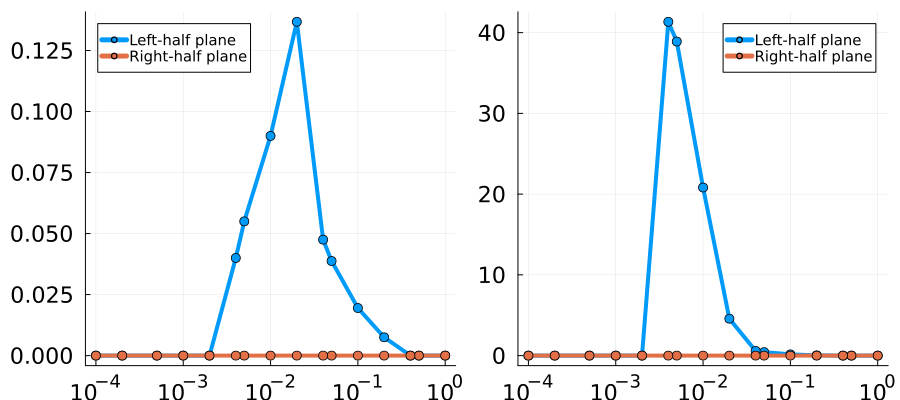

In [77]:
p_1r=Plots.plot();
p_1r=plot!(Delta_x.*(-1),vec(r_left1),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1r=plot!(Delta_x.*(-1),vec(r_right1),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1v=Plots.plot();
p_1v=plot!(Delta_x.*(-1),vec(v_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1v=plot!(Delta_x.*(-1),vec(v_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_1r,p_1v,size=(900,400))

In [79]:
t_1=Table(Δx=Delta_x,ratio_left=vec(r_left1),mean_left=vec(v_left1),ratio_right=vec(r_right1),mean_right=vec(v_right1))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0075      0.0295792  0.0          0.0
 5  │ -0.1     0.0195      0.15178    0.0          0.0
 6  │ -0.05    0.03875     0.432218   0.0          0.0
 7  │ -0.04    0.0475      0.579743   0.0          0.0
 8  │ -0.02    0.13675     4.56962    0.0          0.0
 9  │ -0.01    0.09        20.8151    0.0          0.0
 10 │ -0.005   0.055       38.8981    0.0          0.0
 11 │ -0.004   0.04        41.3386    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=2$, we have

In [81]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left2=zeros(1,length(Delta_x));r_right2=zeros(1,length(Delta_x));
v_left2=zeros(1,length(Delta_x));v_right2=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+2*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left2[j]=length(z_left)/M_s;
    r_right2[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left2[j]=0
    end
    if length(ξ_right)==0
        v_right2[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left2[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right2[j]=mean(μ_right)
    end
end

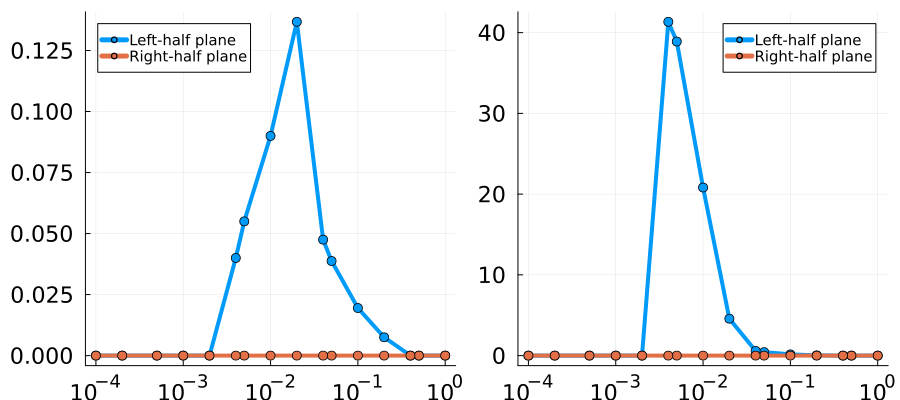

In [83]:
p_2r=Plots.plot();
p_2r=plot!(Delta_x.*(-1),vec(r_left1),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2r=plot!(Delta_x.*(-1),vec(r_right1),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2v=Plots.plot();
p_2v=plot!(Delta_x.*(-1),vec(v_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2v=plot!(Delta_x.*(-1),vec(v_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_2r,p_2v,size=(900,400))

In [85]:
t_2=Table(Δx=Delta_x,ratio_left=vec(r_left2),mean_left=vec(v_left2),ratio_right=vec(r_right2),mean_right=vec(v_right2))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0215      0.119417   0.0          0.0
 7  │ -0.04    0.031       0.23271    0.0          0.0
 8  │ -0.02    0.12525     4.98362    0.0          0.0
 9  │ -0.01    0.09        21.0465    0.0          0.0
 10 │ -0.005   0.055       38.7465    0.0          0.0
 11 │ -0.004   0.04        41.0303    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=3$, we have

In [87]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left3=zeros(1,length(Delta_x));r_right3=zeros(1,length(Delta_x));
v_left3=zeros(1,length(Delta_x));v_right3=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+3*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left3[j]=length(z_left)/M_s;
    r_right3[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left3[j]=0
    end
    if length(ξ_right)==0
        v_right3[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left3[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right3[j]=mean(μ_right)
    end
end

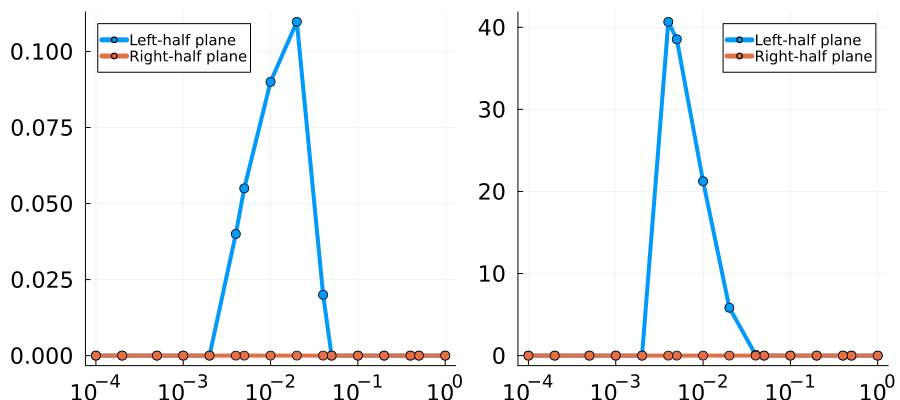

In [89]:
p_3r=Plots.plot();
p_3r=plot!(Delta_x.*(-1),vec(r_left3),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3r=plot!(Delta_x.*(-1),vec(r_right3),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3v=Plots.plot();
p_3v=plot!(Delta_x.*(-1),vec(v_left3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3v=plot!(Delta_x.*(-1),vec(v_right3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_3r,p_3v,size=(900,400))

In [91]:
t_3=Table(Δx=Delta_x,ratio_left=vec(r_left3),mean_left=vec(v_left3),ratio_right=vec(r_right3),mean_right=vec(v_right3))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.02        0.0930999  0.0          0.0
 8  │ -0.02    0.10975     5.83187    0.0          0.0
 9  │ -0.01    0.09        21.245     0.0          0.0
 10 │ -0.005   0.055       38.5392    0.0          0.0
 11 │ -0.004   0.04        40.6654    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=4$, we have

In [93]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left4=zeros(1,length(Delta_x));r_right4=zeros(1,length(Delta_x));
v_left4=zeros(1,length(Delta_x));v_right4=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+4*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left4[j]=length(z_left)/M_s;
    r_right4[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left4[j]=0
    end
    if length(ξ_right)==0
        v_right4[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left4[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right4[j]=mean(μ_right)
    end
end

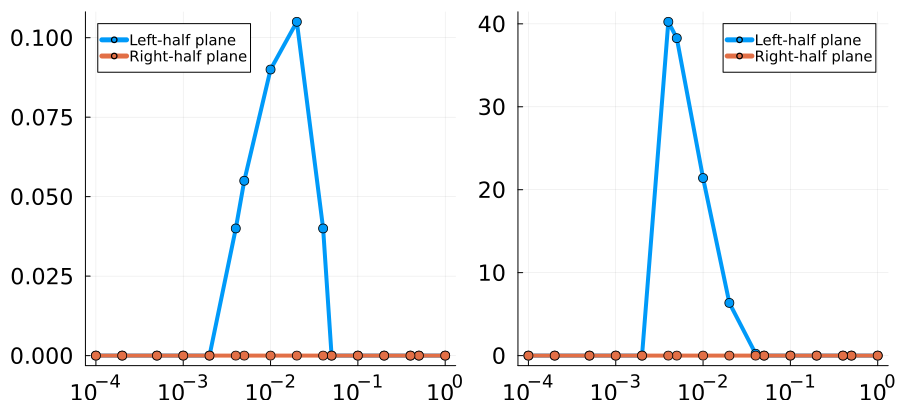

In [95]:
p_4r=Plots.plot();
p_4r=plot!(Delta_x.*(-1),vec(r_left4),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4r=plot!(Delta_x.*(-1),vec(r_right4),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4v=Plots.plot();
p_4v=plot!(Delta_x.*(-1),vec(v_left4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4v=plot!(Delta_x.*(-1),vec(v_right4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_4r,p_4v,size=(900,400))

In [97]:
t_4=Table(Δx=Delta_x,ratio_left=vec(r_left4),mean_left=vec(v_left4),ratio_right=vec(r_right4),mean_right=vec(v_right4))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.04        0.222658   0.0          0.0
 8  │ -0.02    0.105       6.35213    0.0          0.0
 9  │ -0.01    0.09        21.4096    0.0          0.0
 10 │ -0.005   0.055       38.2763    0.0          0.0
 11 │ -0.004   0.04        40.2452    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=5$, we have

In [99]:
p_5=Plots.plot();
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left5=zeros(1,length(Delta_x));r_right5=zeros(1,length(Delta_x));
v_left5=zeros(1,length(Delta_x));v_right5=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+5*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left5[j]=length(z_left)/M_s;
    r_right5[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left5[j]=0
    end
    if length(ξ_right)==0
        v_right5[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left5[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right5[j]=mean(μ_right)
    end
end

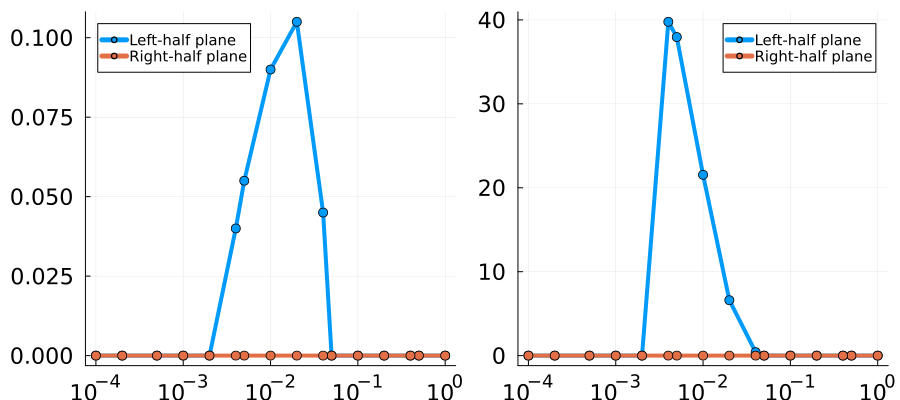

In [101]:
p_5r=Plots.plot();
p_5r=plot!(Delta_x.*(-1),vec(r_left5),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5r=plot!(Delta_x.*(-1),vec(r_right5),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5v=Plots.plot();
p_5v=plot!(Delta_x.*(-1),vec(v_left5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5v=plot!(Delta_x.*(-1),vec(v_right5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_5r,p_5v,size=(900,400))

In [103]:
t_5=Table(Δx=Delta_x,ratio_left=vec(r_left5),mean_left=vec(v_left5),ratio_right=vec(r_right5),mean_right=vec(v_right5))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.045       0.41294    0.0          0.0
 8  │ -0.02    0.105       6.60118    0.0          0.0
 9  │ -0.01    0.09        21.5393    0.0          0.0
 10 │ -0.005   0.055       37.9577    0.0          0.0
 11 │ -0.004   0.04        39.7714    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=6$, we have

In [105]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left6=zeros(1,length(Delta_x));r_right6=zeros(1,length(Delta_x));
v_left6=zeros(1,length(Delta_x));v_right6=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+6*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left6[j]=length(z_left)/M_s;
    r_right6[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left6[j]=0
    end
    if length(ξ_right)==0
        v_right6[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left6[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right6[j]=mean(μ_right)
    end
end

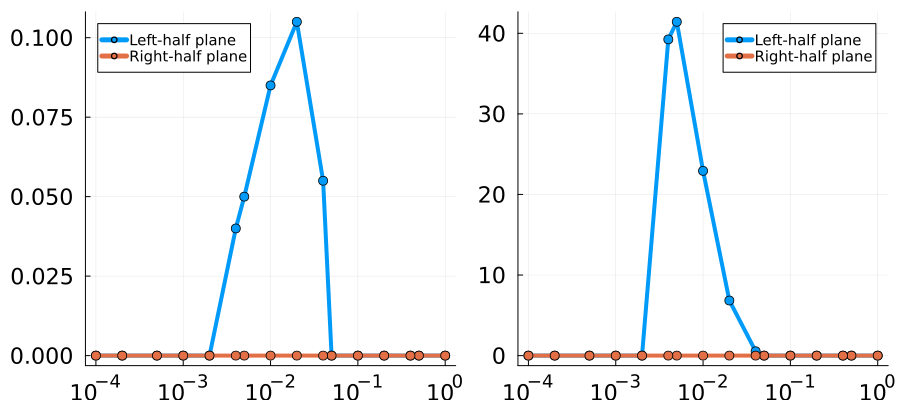

In [107]:
p_6r=Plots.plot();
p_6r=plot!(Delta_x.*(-1),vec(r_left6),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6r=plot!(Delta_x.*(-1),vec(r_right6),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6v=Plots.plot();
p_6v=plot!(Delta_x.*(-1),vec(v_left6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6v=plot!(Delta_x.*(-1),vec(v_right6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_6r,p_6v,size=(900,400))

In [109]:
t_6=Table(Δx=Delta_x,ratio_left=vec(r_left6),mean_left=vec(v_left6),ratio_right=vec(r_right6),mean_right=vec(v_right6))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.055       0.53841    0.0          0.0
 8  │ -0.02    0.105       6.83716    0.0          0.0
 9  │ -0.01    0.085       22.9244    0.0          0.0
 10 │ -0.005   0.05        41.425     0.0          0.0
 11 │ -0.004   0.04        39.2451    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=7$, we have

In [111]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left7=zeros(1,length(Delta_x));r_right7=zeros(1,length(Delta_x));
v_left7=zeros(1,length(Delta_x));v_right7=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+7*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left7[j]=length(z_left)/M_s;
    r_right7[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left7[j]=0
    end
    if length(ξ_right)==0
        v_right7[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left7[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right7[j]=mean(μ_right)
    end
end

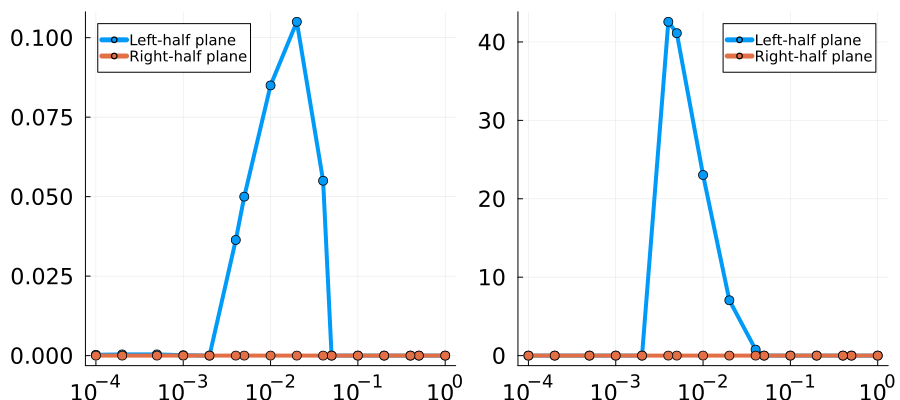

In [113]:
p_7r=Plots.plot();
p_7r=plot!(Delta_x.*(-1),vec(r_left7),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7r=plot!(Delta_x.*(-1),vec(r_right7),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7v=Plots.plot();
p_7v=plot!(Delta_x.*(-1),vec(v_left7),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7v=plot!(Delta_x.*(-1),vec(v_right7),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_7r,p_7v,size=(900,400))

In [115]:
t_7=Table(Δx=Delta_x,ratio_left=vec(r_left7),mean_left=vec(v_left7),ratio_right=vec(r_right7),mean_right=vec(v_right7))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌──────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.0          0.0
 2  │ -0.5     0.0         0.0          0.0          0.0
 3  │ -0.4     0.0         0.0          0.0          0.0
 4  │ -0.2     0.0         0.0          0.0          0.0
 5  │ -0.1     0.0         0.0          0.0          0.0
 6  │ -0.05    0.0         0.0          0.0          0.0
 7  │ -0.04    0.055       0.758912     0.0          0.0
 8  │ -0.02    0.105       7.05907      0.0          0.0
 9  │ -0.01    0.085       23.0333      0.0          0.0
 10 │ -0.005   0.05        41.1244      0.0          0.0
 11 │ -0.004   0.036375    42.5696      0.0          0.0
 12 │ -0.002   0.0         0.0          0.0          0.0
 13 │ -0.001   0.000125    6.66134e-13  0.0          0.0
 14 │ -0.0005  0.000375    3.55271e-12  0.0          0.0
 15 │ -0.0002  0.000375    7.03141e-12  

For $x=8$, we have

In [117]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left8=zeros(1,length(Delta_x));r_right8=zeros(1,length(Delta_x));
v_left8=zeros(1,length(Delta_x));v_right8=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+8*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left8[j]=length(z_left)/M_s;
    r_right8[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left8[j]=0
    end
    if length(ξ_right)==0
        v_right8[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left8[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right8[j]=mean(μ_right)
    end
end

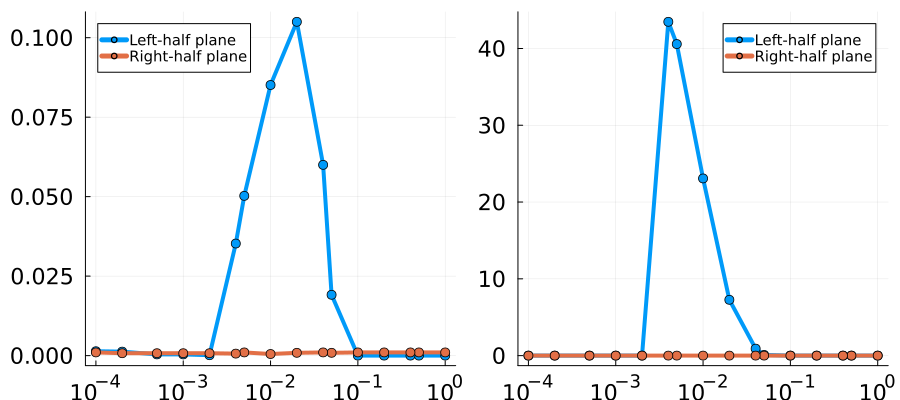

In [119]:
p_8r=Plots.plot();
p_8r=plot!(Delta_x.*(-1),vec(r_left8),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8r=plot!(Delta_x.*(-1),vec(r_right8),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8v=Plots.plot();
p_8v=plot!(Delta_x.*(-1),vec(v_left8),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8v=plot!(Delta_x.*(-1),vec(v_right8),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_8r,p_8v,size=(900,400))

In [120]:
t_8=Table(Δx=Delta_x,ratio_left=vec(r_left8),mean_left=vec(v_left8),ratio_right=vec(r_right8),mean_right=vec(v_right8))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001        5.68573e-13
 2  │ -0.5     0.0         0.0          0.001        5.6577e-13
 3  │ -0.4     0.0         0.0          0.001        5.69891e-13
 4  │ -0.2     0.0         0.0          0.001        5.73014e-13
 5  │ -0.1     0.0         0.0          0.001        5.63993e-13
 6  │ -0.05    0.019125    0.0867905    0.000875     6.66134e-13
 7  │ -0.04    0.06        0.905183     0.001        5.91194e-13
 8  │ -0.02    0.105       7.26588      0.000875     6.07451e-13
 9  │ -0.01    0.085125    23.0736      0.0005       1.04361e-12
 10 │ -0.005   0.05025     40.5752      0.001        5.21805e-13
 11 │ -0.004   0.03525     43.4721      0.000625     9.54792e-13
 12 │ -0.002   0.000125    1.11022e-13  0.00075      7.9566e-13
 13 │ -0.001   0.000375    1.25825e-12  0.00075      1.0732

For $x=9$, we have

In [121]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left9=zeros(1,length(Delta_x));r_right9=zeros(1,length(Delta_x));
v_left9=zeros(1,length(Delta_x));v_right9=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+9*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left9[j]=length(z_left)/M_s;
    r_right9[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left9[j]=0
    end
    if length(ξ_right)==0
        v_right9[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left9[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right9[j]=mean(μ_right)
    end
end

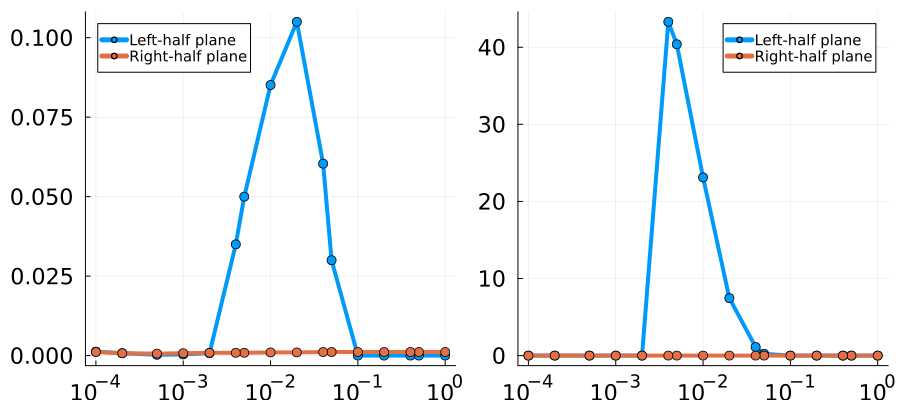

In [122]:
p_9r=Plots.plot();
p_9r=plot!(Delta_x.*(-1),vec(r_left9),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9r=plot!(Delta_x.*(-1),vec(r_right9),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9v=Plots.plot();
p_9v=plot!(Delta_x.*(-1),vec(v_left9),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9v=plot!(Delta_x.*(-1),vec(v_right9),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_9r,p_9v,size=(900,400))

In [123]:
t_9=Table(Δx=Delta_x,ratio_left=vec(r_left9),mean_left=vec(v_left9),ratio_right=vec(r_right9),mean_right=vec(v_right9))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     6.7393e-13
 2  │ -0.5     0.0         0.0          0.001125     6.75756e-13
 3  │ -0.4     0.0         0.0          0.001125     6.74337e-13
 4  │ -0.2     0.0         0.0          0.001125     6.77853e-13
 5  │ -0.1     0.0         0.0          0.001125     6.83651e-13
 6  │ -0.05    0.03        0.231015     0.001125     6.71562e-13
 7  │ -0.04    0.060375    1.11028      0.001125     6.86488e-13
 8  │ -0.02    0.105       7.45654      0.001        7.53564e-13
 9  │ -0.01    0.085125    23.1123      0.001        9.10383e-13
 10 │ -0.005   0.05        40.3866      0.000875     7.48608e-13
 11 │ -0.004   0.035       43.295       0.000875     8.40597e-13
 12 │ -0.002   0.00075     3.33067e-13  0.000875     1.28469e-12
 13 │ -0.001   0.000375    1.11022e-12  0.00075      2.368

For $x=10$, we have

In [124]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left10=zeros(1,length(Delta_x));r_right10=zeros(1,length(Delta_x));
v_left10=zeros(1,length(Delta_x));v_right10=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+10*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left10[j]=length(z_left)/M_s;
    r_right10[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left10[j]=0
    end
    if length(ξ_right)==0
        v_right10[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left10[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right10[j]=mean(μ_right)
    end
end

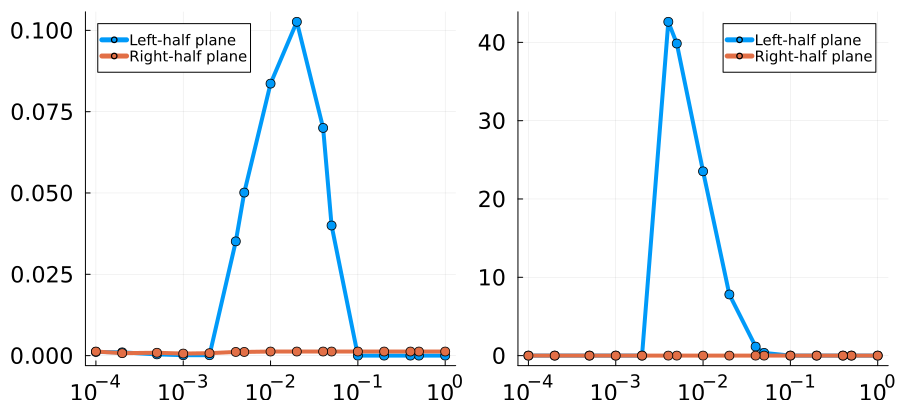

In [125]:
p_10r=Plots.plot();
p_10r=plot!(Delta_x.*(-1),vec(r_left10),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10r=plot!(Delta_x.*(-1),vec(r_right10),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10v=Plots.plot();
p_10v=plot!(Delta_x.*(-1),vec(v_left10),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10v=plot!(Delta_x.*(-1),vec(v_right10),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_10r,p_10v,size=(900,400))

In [126]:
t_10=Table(Δx=Delta_x,ratio_left=vec(r_left10),mean_left=vec(v_left10),ratio_right=vec(r_right10),mean_right=vec(v_right10))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.00125      6.95088e-13
 2  │ -0.5     0.0         0.0          0.00125      6.94467e-13
 3  │ -0.4     0.0         0.0          0.00125      6.96387e-13
 4  │ -0.2     0.0         0.0          0.00125      6.98996e-13
 5  │ -0.1     0.0         0.0          0.00125      6.90115e-13
 6  │ -0.05    0.04        0.342579     0.00125      6.92335e-13
 7  │ -0.04    0.07        1.14627      0.00125      7.08877e-13
 8  │ -0.02    0.102625    7.80754      0.00125      7.09433e-13
 9  │ -0.01    0.083625    23.5304      0.00125      8.41549e-13
 10 │ -0.005   0.050125    39.8509      0.001125     7.74689e-13
 11 │ -0.004   0.035125    42.6221      0.001125     8.75843e-13
 12 │ -0.002   0.000125    8.88178e-13  0.00075      1.44329e-12
 13 │ -0.001   0.000125    6.66134e-13  0.000625     2.88

For $x=11$, we have

In [127]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left11=zeros(1,length(Delta_x));r_right11=zeros(1,length(Delta_x));
v_left11=zeros(1,length(Delta_x));v_right11=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+11*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left11[j]=length(z_left)/M_s;
    r_right11[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left11[j]=0
    end
    if length(ξ_right)==0
        v_right11[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left11[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right11[j]=mean(μ_right)
    end
end

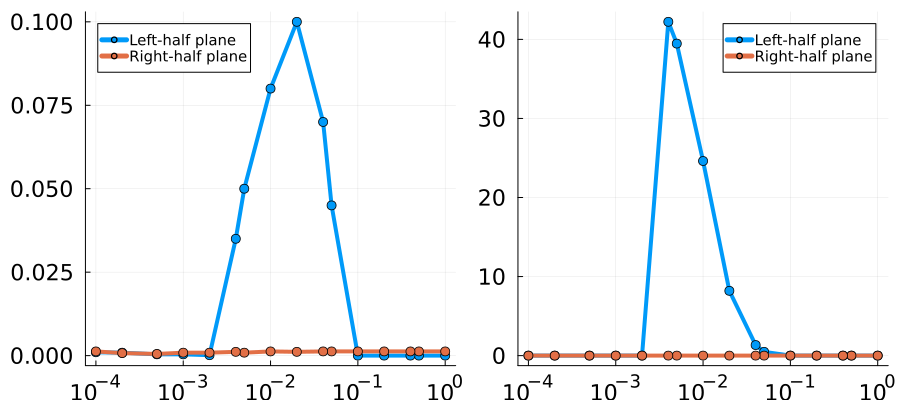

In [128]:
p_11r=Plots.plot();
p_11r=plot!(Delta_x.*(-1),vec(r_left11),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11r=plot!(Delta_x.*(-1),vec(r_right11),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11v=Plots.plot();
p_11v=plot!(Delta_x.*(-1),vec(v_left11),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11v=plot!(Delta_x.*(-1),vec(v_right11),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_11r,p_11v,size=(900,400))

In [129]:
t_11=Table(Δx=Delta_x,ratio_left=vec(r_left11),mean_left=vec(v_left11),ratio_right=vec(r_right11),mean_right=vec(v_right11))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.00125      7.16893e-13
 2  │ -0.5     0.0         0.0          0.00125      7.17471e-13
 3  │ -0.4     0.0         0.0          0.00125      7.16482e-13
 4  │ -0.2     0.0         0.0          0.00125      7.18869e-13
 5  │ -0.1     0.0         0.0          0.00125      7.10543e-13
 6  │ -0.05    0.045       0.474812     0.00125      7.40741e-13
 7  │ -0.04    0.07        1.33385      0.00125      7.32747e-13
 8  │ -0.02    0.1         8.19356      0.001125     7.53718e-13
 9  │ -0.01    0.08        24.6165      0.00125      7.19425e-13
 10 │ -0.005   0.05        39.4699      0.000875     8.56458e-13
 11 │ -0.004   0.035       42.2231      0.001125     1.06088e-12
 12 │ -0.002   0.000125    8.88178e-13  0.000875     8.72318e-13
 13 │ -0.001   0.000375    1.11022e-12  0.000875     1.39

For $x=12$, we have

In [130]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left12=zeros(1,length(Delta_x));r_right12=zeros(1,length(Delta_x));
v_left12=zeros(1,length(Delta_x));v_right12=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+12*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left12[j]=length(z_left)/M_s;
    r_right12[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left12[j]=0
    end
    if length(ξ_right)==0
        v_right12[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left12[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right12[j]=mean(μ_right)
    end
end

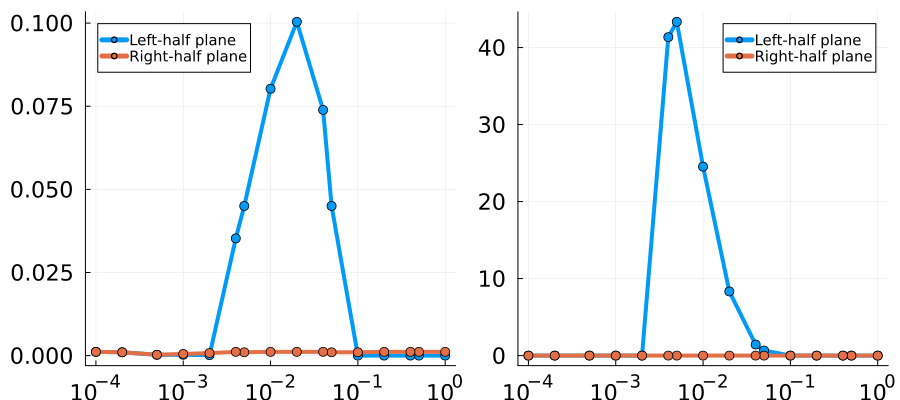

In [131]:
p_12r=Plots.plot();
p_12r=plot!(Delta_x.*(-1),vec(r_left12),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12r=plot!(Delta_x.*(-1),vec(r_right12),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12v=Plots.plot();
p_12v=plot!(Delta_x.*(-1),vec(v_left12),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12v=plot!(Delta_x.*(-1),vec(v_right12),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_12r,p_12v,size=(900,400))

In [132]:
t_12=Table(Δx=Delta_x,ratio_left=vec(r_left12),mean_left=vec(v_left12),ratio_right=vec(r_right12),mean_right=vec(v_right12))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     6.96949e-13
 2  │ -0.5     0.0         0.0          0.001125     6.98503e-13
 3  │ -0.4     0.0         0.0          0.001125     6.99996e-13
 4  │ -0.2     0.0         0.0          0.001125     7.04375e-13
 5  │ -0.1     0.0         0.0          0.001        7.8243e-13
 6  │ -0.05    0.045       0.658912     0.001        7.9714e-13
 7  │ -0.04    0.073875    1.43594      0.001125     7.01908e-13
 8  │ -0.02    0.100375    8.32782      0.001125     6.76002e-13
 9  │ -0.01    0.08025     24.5338      0.001125     6.68601e-13
 10 │ -0.005   0.045       43.3385      0.001        1.06026e-12
 11 │ -0.004   0.03525     41.3485      0.001125     8.38835e-13
 12 │ -0.002   0.000125    5.55112e-13  0.00075      1.22125e-12
 13 │ -0.001   0.00025     2.66454e-12  0.0005       1.6098

For $x=13$, we have

In [133]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left13=zeros(1,length(Delta_x));r_right13=zeros(1,length(Delta_x));
v_left13=zeros(1,length(Delta_x));v_right13=zeros(1,length(Delta_x));
α = [137/60,-5,5,-200/60,75/60,-1/5];β = [1,0,0,0,0,0];
C=A+13*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left13[j]=length(z_left)/M_s;
    r_right13[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left13[j]=0
    end
    if length(ξ_right)==0
        v_right13[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left13[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right13[j]=mean(μ_right)
    end
end

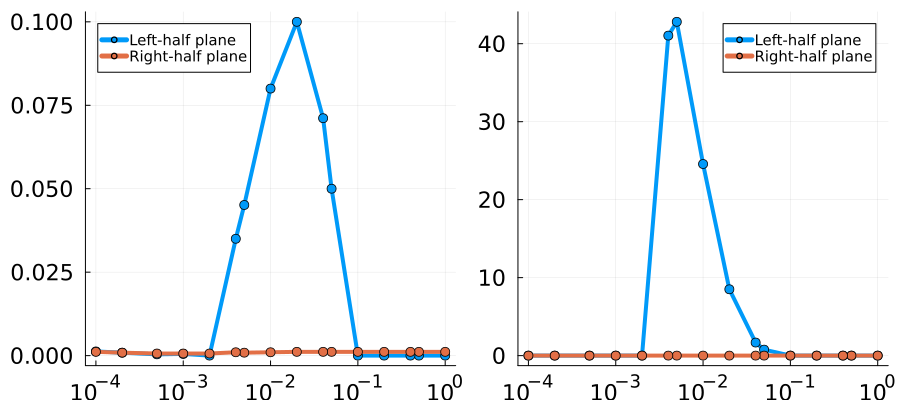

In [134]:
p_13r=Plots.plot();
p_13r=plot!(Delta_x.*(-1),vec(r_left13),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13r=plot!(Delta_x.*(-1),vec(r_right13),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13v=Plots.plot();
p_13v=plot!(Delta_x.*(-1),vec(v_left13),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13v=plot!(Delta_x.*(-1),vec(v_right13),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_13r,p_13v,size=(900,400))

In [135]:
t_13=Table(Δx=Delta_x,ratio_left=vec(r_left13),mean_left=vec(v_left13),ratio_right=vec(r_right13),mean_right=vec(v_right13))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     9.00786e-13
 2  │ -0.5     0.0         0.0          0.001125     9.01402e-13
 3  │ -0.4     0.0         0.0          0.001125     8.99712e-13
 4  │ -0.2     0.0         0.0          0.001125     8.99774e-13
 5  │ -0.1     0.0         0.0          0.001125     9.08903e-13
 6  │ -0.05    0.05        0.764609     0.001125     8.95086e-13
 7  │ -0.04    0.071125    1.67268      0.001125     9.01748e-13
 8  │ -0.02    0.1         8.50662      0.001125     9.17784e-13
 9  │ -0.01    0.08        24.5703      0.001        9.52016e-13
 10 │ -0.005   0.045125    42.807       0.000875     1.33861e-12
 11 │ -0.004   0.035       41.0394      0.001        8.88178e-13
 12 │ -0.002   0.0         0.0          0.000625     1.64313e-12
 13 │ -0.001   0.0005      9.99201e-13  0.000625     3.06

To determine the overall influence of the problematic eigenvalues, we combine the above results.

In [136]:
p_c=Plots.plot();
r_left=((r_leftm10+r_leftm9+r_leftm8+r_leftm7+r_leftm6+r_leftm5+r_leftm4+r_leftm3+r_leftm2+r_leftm1+r_left0+r_left1+r_left2
        +r_left3+r_left4+r_left5+r_left6+r_left7+r_left8+r_left9+r_left10+r_left11+r_left12+r_left13)*M_s) ./ (M_s*24);
r_right=((r_rightm10+r_rightm9+r_rightm8+r_rightm7+r_rightm6+r_rightm5+r_rightm4+r_rightm3+r_rightm2+r_rightm1+r_right0+r_right1
        +r_right2+r_right3+r_right4+r_right5+r_right6+r_right7+r_right8+r_right9+r_right10+r_right11
        +r_right12+r_right13)*M_s) ./ (M_s*24);
v_left=(v_leftm10+v_leftm9+v_leftm8+v_leftm7+v_leftm6+v_leftm5+v_leftm4+v_leftm3+v_leftm2+v_leftm1+v_left0+v_left1+v_left2
        +v_left3+v_left4+v_left5+v_left6+v_left7+v_left8+v_left9+v_left10+v_left11+v_left12+v_left13) ./ 24;
v_right=(v_rightm10+v_rightm9+v_rightm8+v_rightm7+v_rightm6+v_rightm5+v_rightm4+v_rightm3+v_rightm2+v_rightm1+v_right0+v_right1
        +v_right2+v_right3+v_right4+v_right5+v_right6+v_right7+v_right8+v_right9+v_right10+v_right11+v_right12+v_right13) ./ 24;
for i=1:length(r_left)
    if r_left[i]==0
        r_left[i]=10^(-16)
    end
    if r_right[i]==0
        r_right[i]=10^(-16)
    end
    if v_left[i]==0
        v_left[i]=10^(-16)
    end
    if v_right[i]==0
        v_right[i]=10^(-16)
    end
end

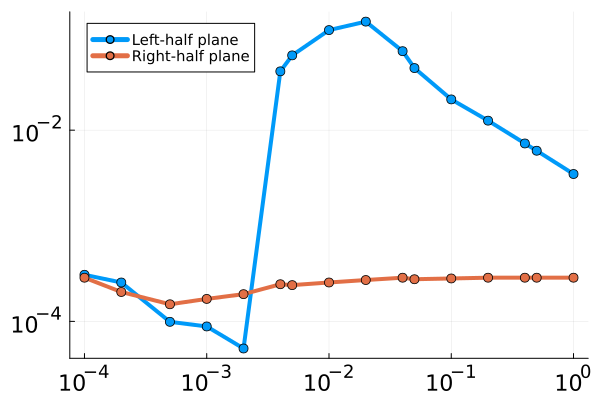

In [137]:
p_r=Plots.plot();
p_r=plot!(Delta_x.*(-1),vec(r_left),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log);
p_r=plot!(Delta_x.*(-1),vec(r_right),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log)

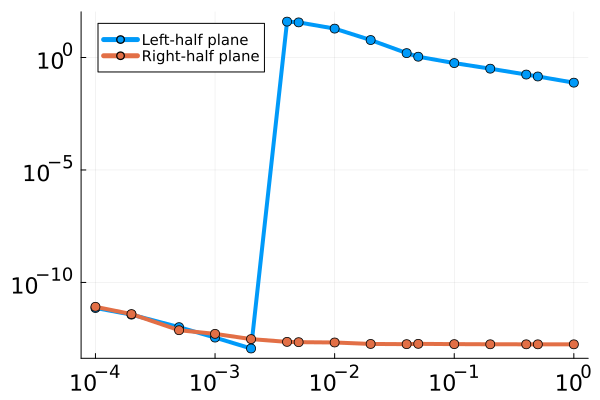

In [139]:
p_v=Plots.plot();
p_v=plot!(Delta_x.*(-1),vec(v_left),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log);
p_v=plot!(Delta_x.*(-1),vec(v_right),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log)

In [142]:
β=2;
TW2=TracyWidom;
xx=-2;
Delta_x=[-1,-0.5,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
err=zeros(1,length(Delta_x));
for i=1:length(Delta_x)
    dx=Delta_x[i];
    result_cdf=TW(β;method="spectral",step="bdf5",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind3=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind3]-cdf(TW2,xx;beta=2,num_points=300));
end
for j=1:length(err)
    if err[j]>1
        err[j]=1
    end
    if err[j]==NaN
        err[j]=1
    end
end

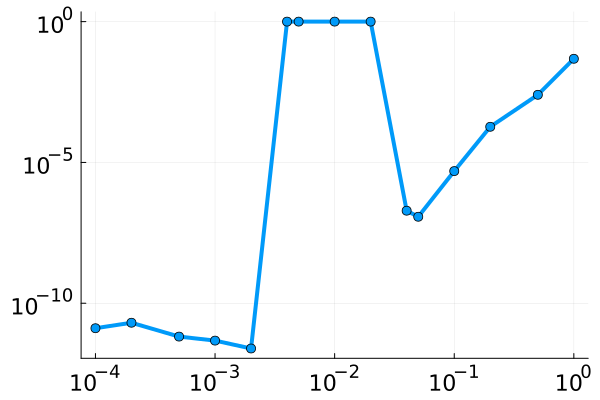

In [151]:
p_e=Plots.plot();
p_e=plot!(Delta_x.*(-1),vec(err),lw=4,legend=false,marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
    xaxis=:log,yaxis=:log)

The gap is about $[-0.04,-0.004]$ for BDF5.